<a href="https://colab.research.google.com/github/teticio/audio-diffusion/blob/master/notebooks/test_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # are we running on Google Colab?
    import google.colab
    !git clone -q https://github.com/teticio/audio-diffusion.git
    %cd audio-diffusion
    !pip install -q -r requirements.txt
except:
    pass

In [2]:
import os
import sys
sys.path.insert(0, os.path.dirname(os.path.abspath("")))

In [3]:
import random
from datasets import load_dataset
from IPython.display import Audio
from audiodiffusion.mel import Mel
from audiodiffusion import AudioDiffusion

### Select model

In [ ]:
#@markdown teticio/audio-diffusion-256        - trained on my Spotify "liked" playlist

#@markdown teticio/audio-diffusion-256-breaks - trained on samples used in music

model_id = "teticio/audio-diffusion-256"  #@param ["teticio/audio-diffusion-256", "teticio/audio-diffusion-256-breaks"]

### Run model inference to generate mel spectrogram, audios and loops

In [4]:
audio_diffusion = AudioDiffusion(model_id=model_id)

In [ ]:
while True:
    image, (sample_rate, audio) = audio_diffusion.generate_spectrogram_and_audio()
    display(image)
    display(Audio(audio, rate=sample_rate))
    loop = AudioDiffusion.loop_it(audio, sample_rate)
    if loop is not None:
        display(Audio(loop, rate=sample_rate))
    else:
        print("Unable to determine loop points")

### Compare results with random sample from training set

In [12]:
mel = Mel(x_res=256, y_res=256)

In [ ]:
ds = load_dataset(model_id)

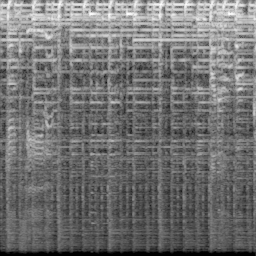

In [16]:
image = random.choice(ds['train'])['image']
image

In [17]:
audio = mel.image_to_audio(image)
Audio(data=audio, rate=mel.get_sample_rate())